In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import cupy as cp

In [7]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/LV/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux.h5"
# NORM_PATH = "/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/norm/spectra.h5"
sys.path.insert(0, PROJECT_PATH)

### Load data

In [8]:
with h5py.File(NORM_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [9]:
flux0.shape, wave0.shape

((116614, 15404), (15404,))

In [10]:
from lv.base.dataloader_c import DataLoader

In [98]:
ds = DataLoader()

In [99]:
ds.prepare_data (flux0, wave0, para0, "Red_M", "BHB", fix_CO=0)

Cupy flux: 3300, wave: 2204


# find masking 

In [162]:
u,w,v = ds._svd(ds.flux[:, :])

In [228]:
w[:10]

array([113.370155  ,  11.782064  ,   8.755681  ,   3.318766  ,
         1.3461212 ,   1.0364841 ,   0.8614032 ,   0.6409531 ,
         0.52222764,   0.4007302 ], dtype=float32)

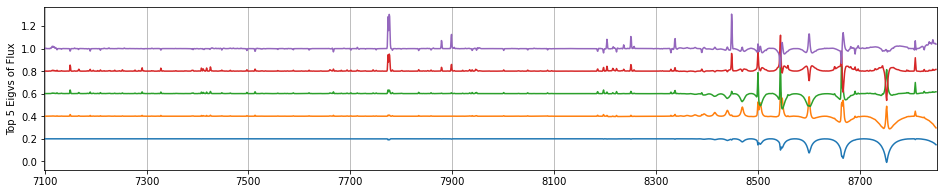

In [164]:
ds.plot_eigv(cp.asnumpy(v), name="Flux", step=0.2)

In [169]:
k,q,prom = 10, 0.6, 0.1
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

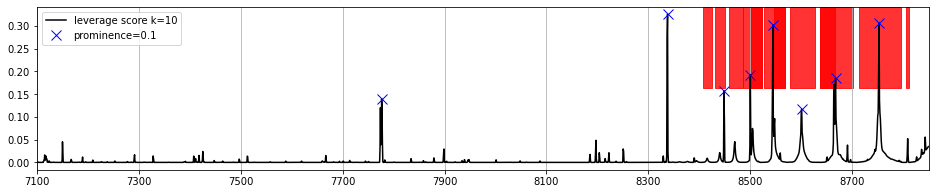

In [170]:
ds.plot_peaks(nvv, peaks, k, prom)

In [171]:
ds.get_mask_from_peaks(peaks,prop)

Text(0.5, 1.0, 'k=10, q=0.6, prom=0.1')

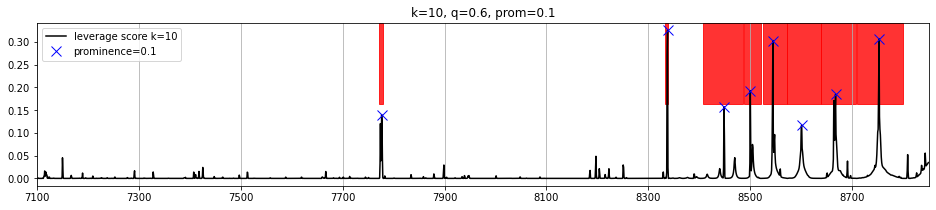

In [172]:
ds.plot_peaks(nvv, peaks, k, prom)
plt.title(f"k={k}, q={q}, prom={prom}")

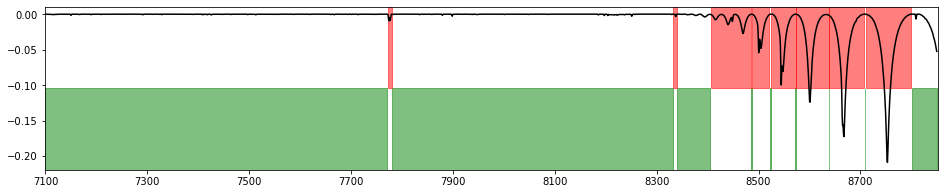

In [173]:
ds.plot_MN_mask(v[:1])

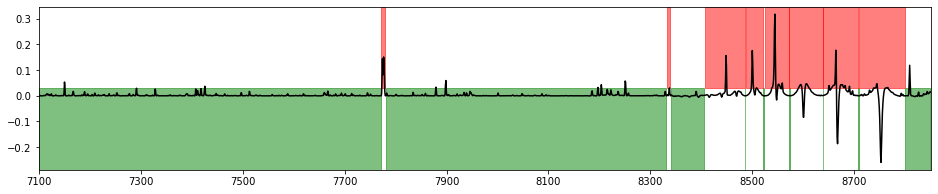

In [174]:
ds.plot_MN_mask(v[3:4])

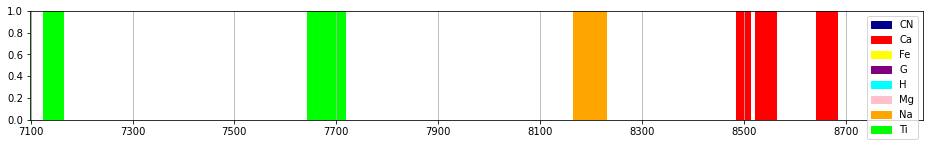

In [175]:
ds.plot_lick()

In [176]:
ds.get_MN(ds.mask, top=5)

(0.0, 1.4057623781263828)

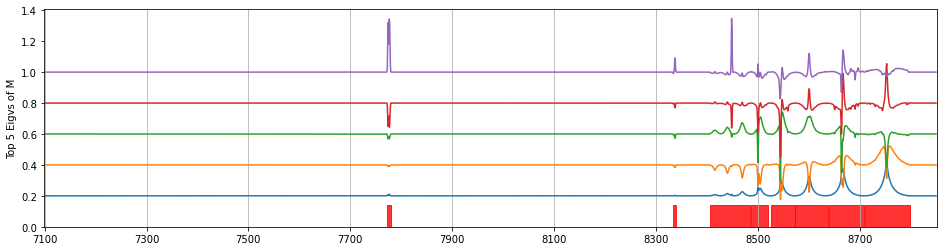

In [178]:
step = 0.2
axs = plt.subplots(1,figsize=(16,4))[1]
ds.plot_eigv(ds.Mv, mask=None, name="M", step=step, ax=axs)
ds.plot_masked(ax=axs, ymin=0, ymax=0.1)
axs.set_ylim(0.0, None)

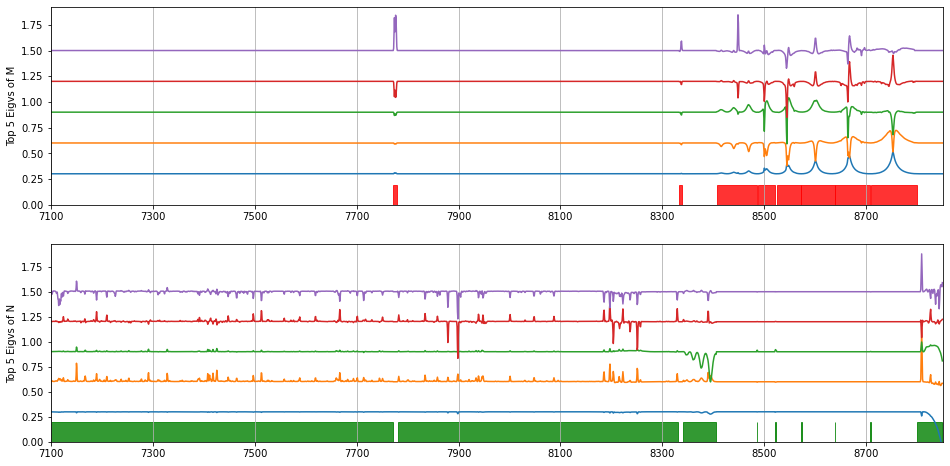

In [179]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_MN(step=0.3, axs=axs)

In [180]:
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-6, mu=None, lam=None, norm=None, maxiter=1000)

24.771328 0.017407765595569783 12809.727


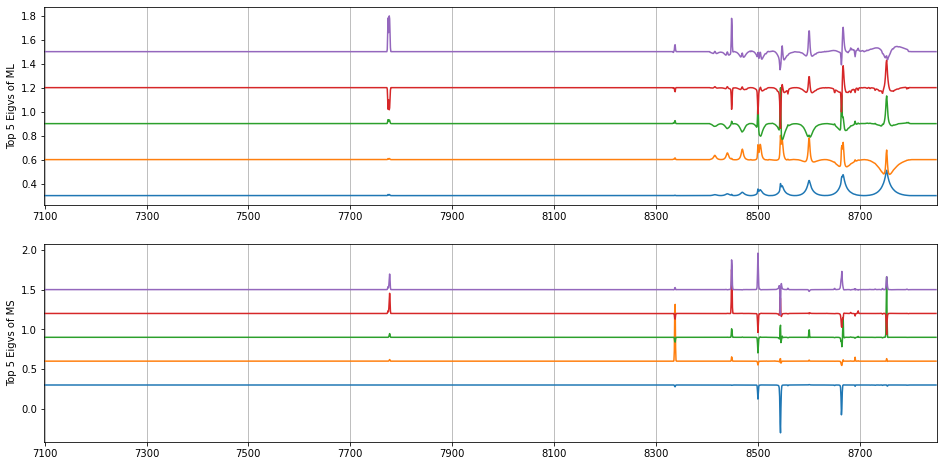

In [181]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_eigv(MLv, name="ML", ax=axs[0])
ds.plot_eigv(MSv, name="MS", ax=axs[1])

In [182]:
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=None, lam=None, norm=None, maxiter=1000)

283.78497 0.017407765595569783 274.2931


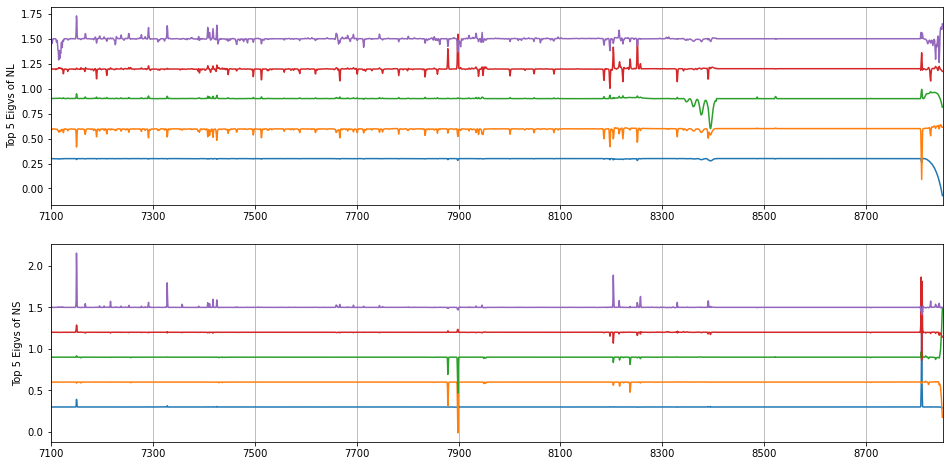

In [183]:
f, axs = plt.subplots(2,1,figsize=(16,8), facecolor="w")
ds.plot_eigv(NLv, name="NL", ax=axs[0])
ds.plot_eigv(NSv, name="NS", ax=axs[1])

In [184]:
ds.pcp_transform(MLv, MSv, NLv, NSv)

In [191]:
pcp20 = cp.vstack([MLv[:5],MSv,NLv[:5],NSv])

In [241]:
Models = ds.dfpara.values

In [242]:
ds.dfpara

F       T    L     C     O        p0        p1        p2        p3  \
2965  -2.5  7000.0  3.5 -0.50 -0.25  1.181071  0.259177  0.092670  0.107825   
2966  -2.5  7000.0  3.5 -0.50  0.00  1.189505  0.268641  0.106059  0.090862   
2967  -2.5  7000.0  3.5 -0.50  0.25  1.199843  0.279622  0.121984  0.070071   
2968  -2.5  7000.0  3.5 -0.50  0.50  1.213856  0.293005  0.140740  0.043499   
2969  -2.5  7000.0  3.5 -0.25 -0.25  1.181448  0.259124  0.092511  0.107587   
...    ...     ...  ...   ...   ...       ...       ...       ...       ...   
37738 -1.5  9500.0  4.5  0.25  0.50  1.972619 -0.361667  0.098458 -0.074954   
37739 -1.5  9500.0  4.5  0.50 -0.25  1.963455 -0.382066  0.066688 -0.006516   
37740 -1.5  9500.0  4.5  0.50  0.00  1.967594 -0.375765  0.076487 -0.026178   
37741 -1.5  9500.0  4.5  0.50  0.25  1.971925 -0.369258  0.087107 -0.049333   
37742 -1.5  9500.0  4.5  0.50  0.50  1.975403 -0.362182  0.098637 -0.075610   

             p4  ...       p10       p11       p12       p13       p14  \
2965   0.021091  ... -0.089790 -0.013709 -0.020601 -0.006984 -0.000870   
2966   0.016997  ... -0.090221 -0.018948 -0.019527 -0.004973  0.000283   
2967   0.012987  ... -0.091213 -0.026728 -0.017812 -0.001950  0.002062   
2968   0.009340  ... -0.092196 -0.036837 -0.015547  0.002398  0.005011   
2969   0.021173  ... -0.089882 -0.013867 -0.020670 -0.007039 -0.001100   
...         ...  ...       ...       ...       ...       ...       ...   
37738  0.050652  ... -0.428307  0.008883  0.033176  0.021670 -0.008343   
37739  0.010627  ... -0.428699  0.028719  0.029373 -0.003606 -0.008180   
37740  0.021040  ... -0.428972  0.024536  0.030200  0.001728 -0.008946   
37741  0.034975  ... -0.429746  0.018007  0.031580  0.009973 -0.010115   
37742  0.051411  ... -0.430806  0.008565  0.033632  0.021887 -0.011627   

            p15       p16       p17       p18       p19  
2965   0.008856 -0.038241  0.049941 -0.005994  0.005772  
2966   0.015278 -0.038684  0.049928 -0.004346  0.006867  
2967   0.024211 -0.039674  0.049919 -0.002021  0.008955  
2968   0.035024 -0.040973  0.049664  0.000835  0.012762  
2969   0.008861 -0.038294  0.049902 -0.006021  0.005794  
...         ...       ...       ...       ...       ...  
37738  0.015853 -0.197237  0.205918 -0.029907  0.020303  
37739 -0.000884 -0.177064  0.220882 -0.033998  0.015636  
37740  0.002691 -0.181388  0.217789 -0.033164  0.016504  
37741  0.008171 -0.188179  0.213145 -0.031904  0.018029  
37742  0.015821 -0.197885  0.206386 -0.030163  0.020598  

[3300 rows x 25 columns]

In [245]:
MODEL_PATH = "/scratch/ceph/swei20/data/dnn/DNN_BHB_RedM_n3300.h5"

In [248]:
Models[:,5:].shape

(3300, 20)

In [249]:
with h5py.File(MODEL_PATH, 'w') as f:
    f.create_dataset('para', data = Models[:,:5], shape=Models[:,:5].shape)
    f.create_dataset('flux', data = Models[:,5:], shape=Models[:,5:].shape)
    f.create_dataset('pcp', data = pcp20n, shape=pcp20n.shape)
    

In [243]:
Models.shape

(3300, 25)

In [236]:
TRAIN_DIR = "/scratch/ceph/swei20/data/ae/"
TRAIN_PATH2 = os.path.join(TRAIN_DIR, "PCP_100k_BHB_RedM.h5")

In [252]:
flux20 = Models[:,5:]

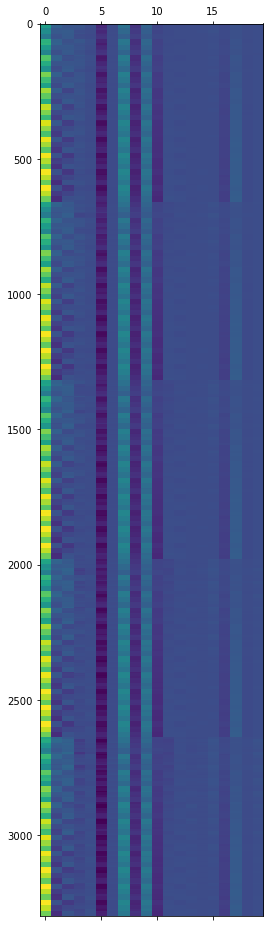

In [253]:
plt.matshow(flux20, aspect="auto")

In [237]:
TRAIN_PATH2

'/scratch/ceph/swei20/data/ae/PCP_100k_BHB_RedM.h5'

In [226]:
ds.flux.shape

(3300, 2204)

In [196]:
TRAIN_PATH

'/scratch/ceph/swei20/data/ae/PCP_100k_BHB_RedM.h5'

In [203]:
with h5py.File(TRAIN_PATH, "r") as f:
    flux_t = f["flux"][()]
    wave_t = f["wave"][()]  
    para_t = f["pval"][()]        

In [204]:
flux_t.shape

(100000, 2204)

In [205]:
pcp20n = cp.asnumpy(pcp20)

In [208]:
flux_t20 = np.dot(flux_t, pcp20n.T)

In [231]:
flux_t20.shape

(100000, 20)

In [234]:
para_t.shape

(100000, 5)

In [213]:
para_t.shape

(100000, 5)

In [230]:
TRAIN_DIR = "/scratch/ceph/swei20/data/dnn/"
TRAIN_PATH = os.path.join(TRAIN_DIR, "DNN_BHB_RedM.h5")

In [239]:
TRAIN_PATH

'/scratch/ceph/swei20/data/dnn/DNN_BHB_RedM.h5'

In [251]:
flux.shape

NameError: name 'flux20' is not defined

In [ ]:
plt.matshow(flux20)

In [250]:
pcp20n.shape

(20, 2204)

In [238]:
with h5py.File(TRAIN_PATH, 'w') as f:
    f.create_dataset('flux', data = flux_t20, shape=flux_t20.shape)
    f.create_dataset('PCP_PATH', data = TRAIN_PATH2)
    f.create_dataset('para', data = para_t, shape=para_t.shape)
    f.create_dataset('pcp', data = pcp20n, shape=pcp20n.shape)
    

In [216]:
from matplotlib import cm

In [218]:
para_t[:,1].shape

(100000,)

Text(0.5, 1.0, 'BlueHB in RedM R=5000 from RBF')

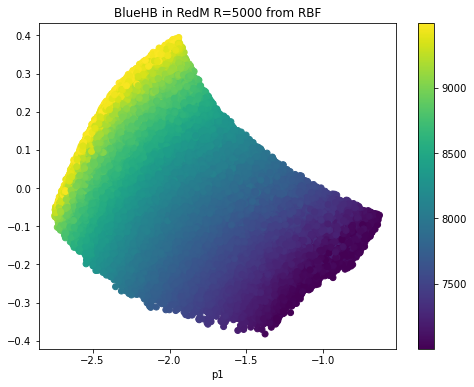

In [225]:
plt.figure(figsize=(8,6), facecolor="w")
plt.scatter(flux_t20[:,0], flux_t20[:,1], c =para_t[:,1] )
plt.colorbar()
plt.xlabel("p0")
plt.xlabel("p1")
plt.title("BlueHB in RedM R=5000 from RBF")

In [ ]:
SAVE_PATH = 

In [ ]:
with h5py.File(SAVE_PATH, 'w') as f:
    f.create_dataset('PC', data = train_pc, shape=train_pc.shape)
    f.create_dataset('RBF_PATH', data = RBF_PATH)
    f.create_dataset('eigv', data = rbf.grid.eigv['flux'])

In [192]:
MLv.shape

(239, 2204)

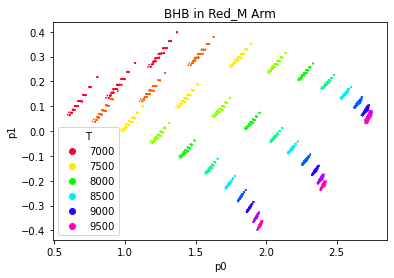

In [185]:
ds.p(0,1,"T",large=0)

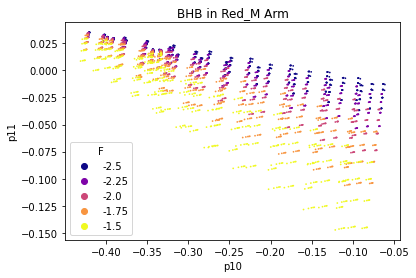

In [186]:
ds.p(10,11,"F")

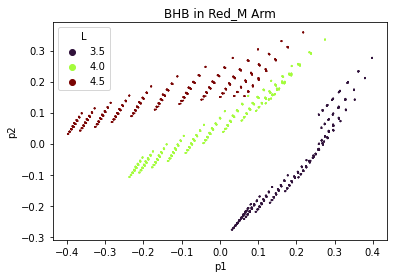

In [187]:
ds.p(1,2,"L")

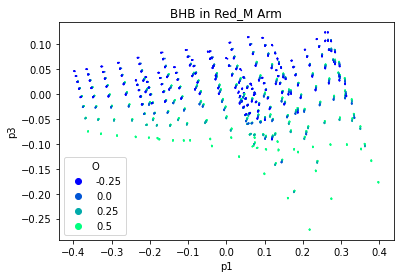

In [188]:
ds.p(1,3,"O")

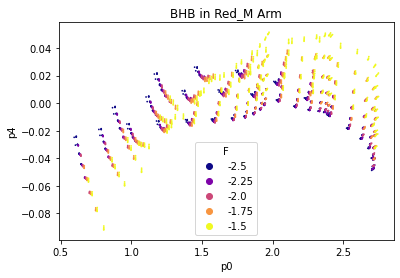

In [189]:
ds.p(0,4,"F")

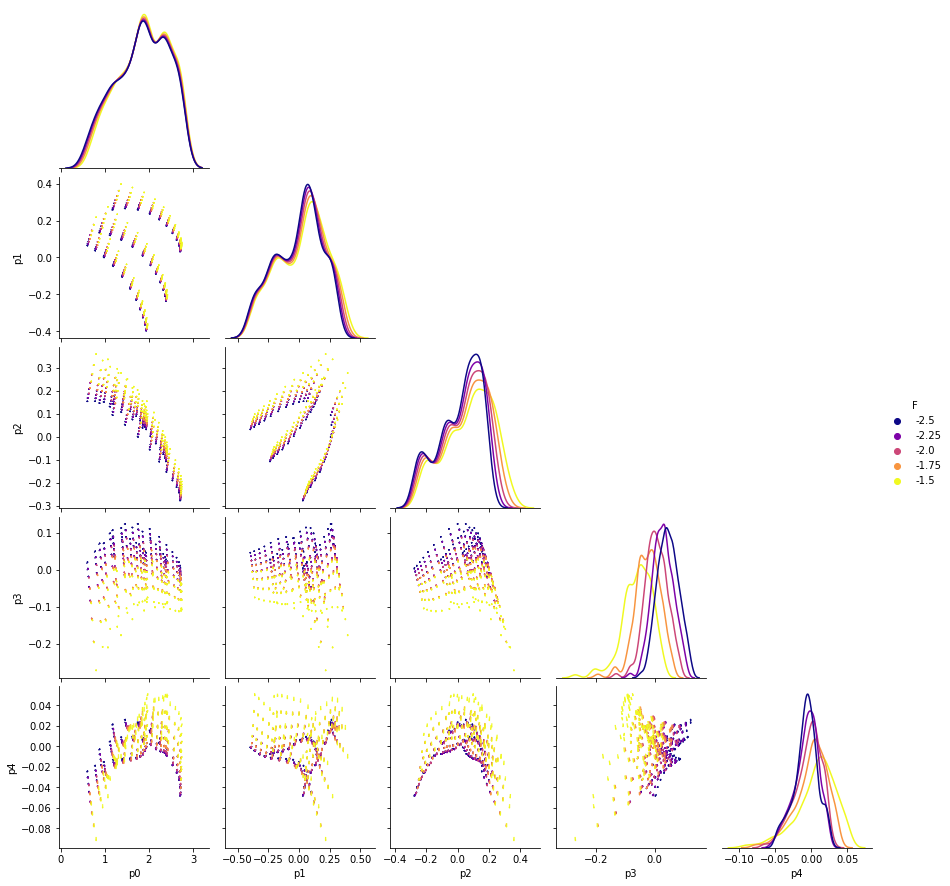

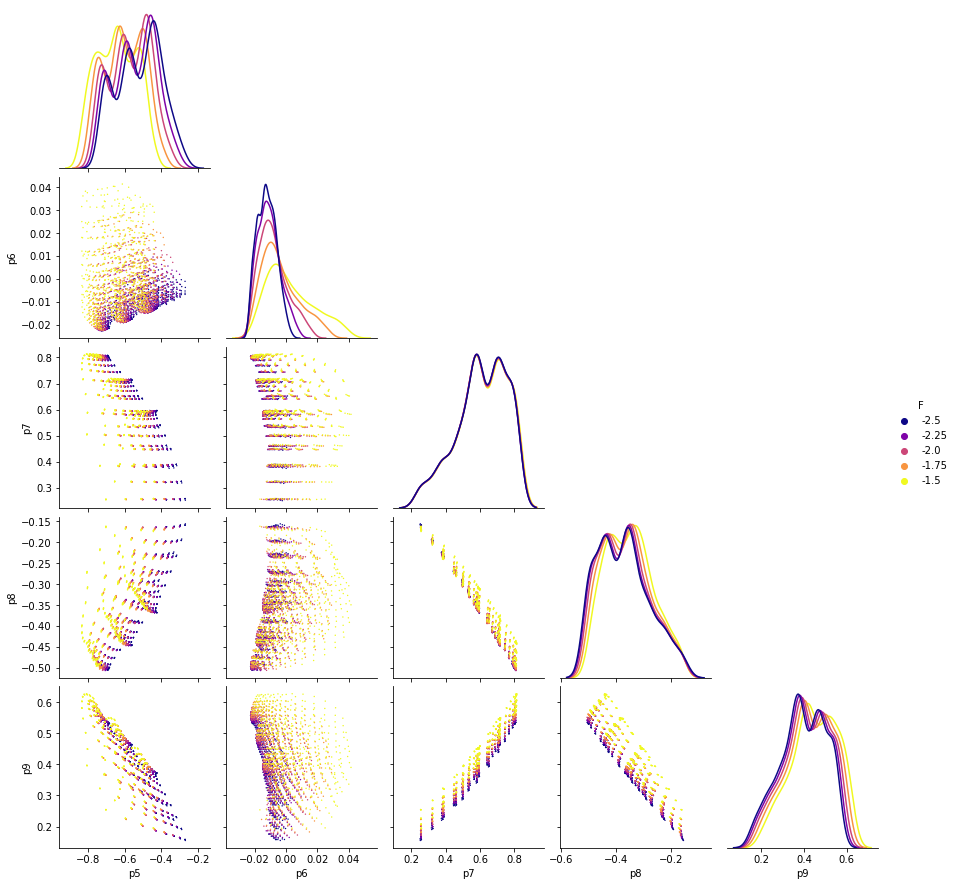

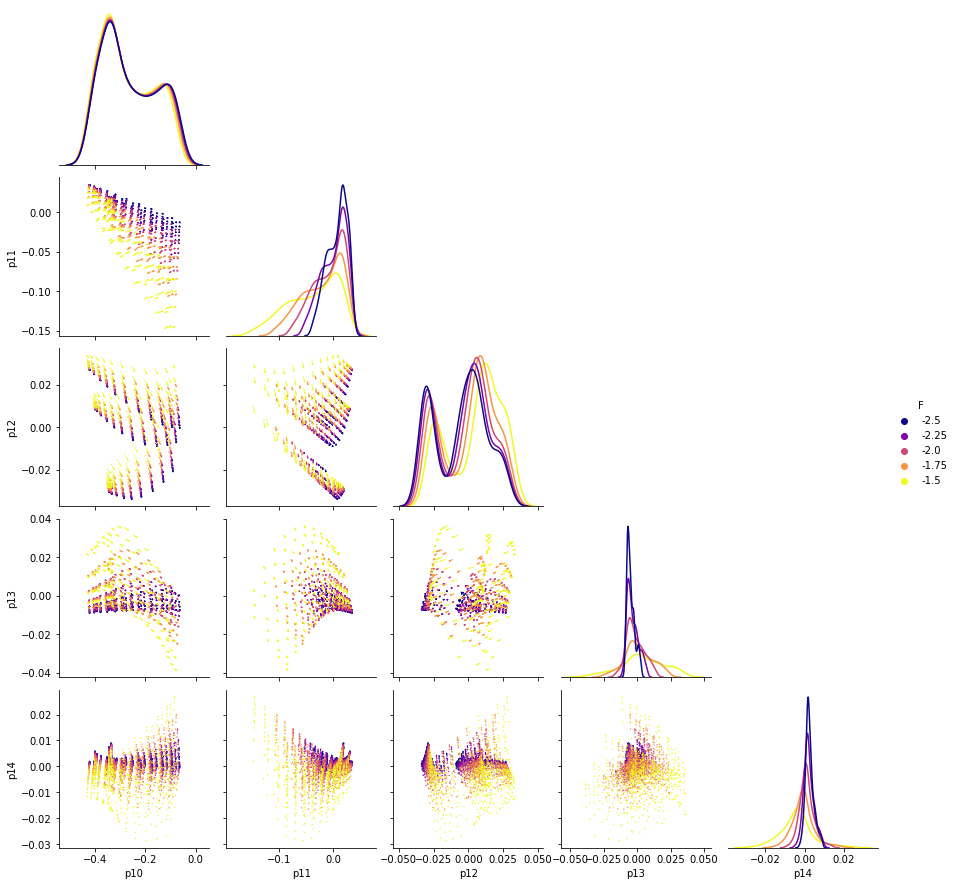

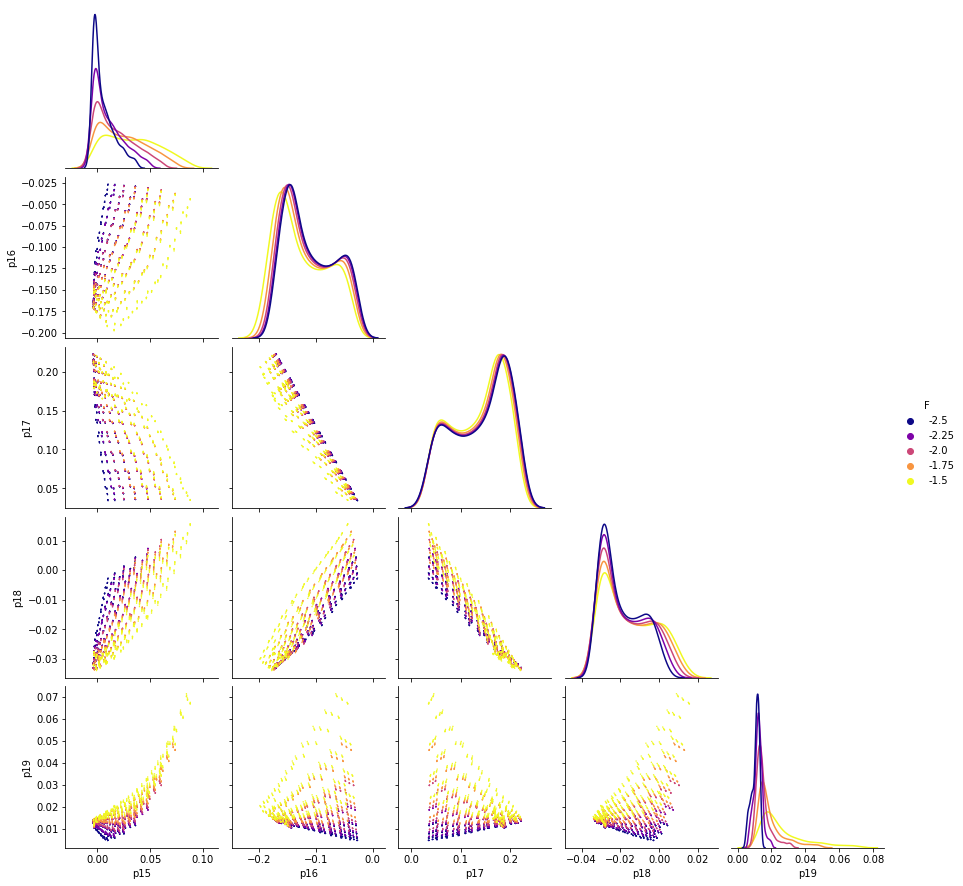

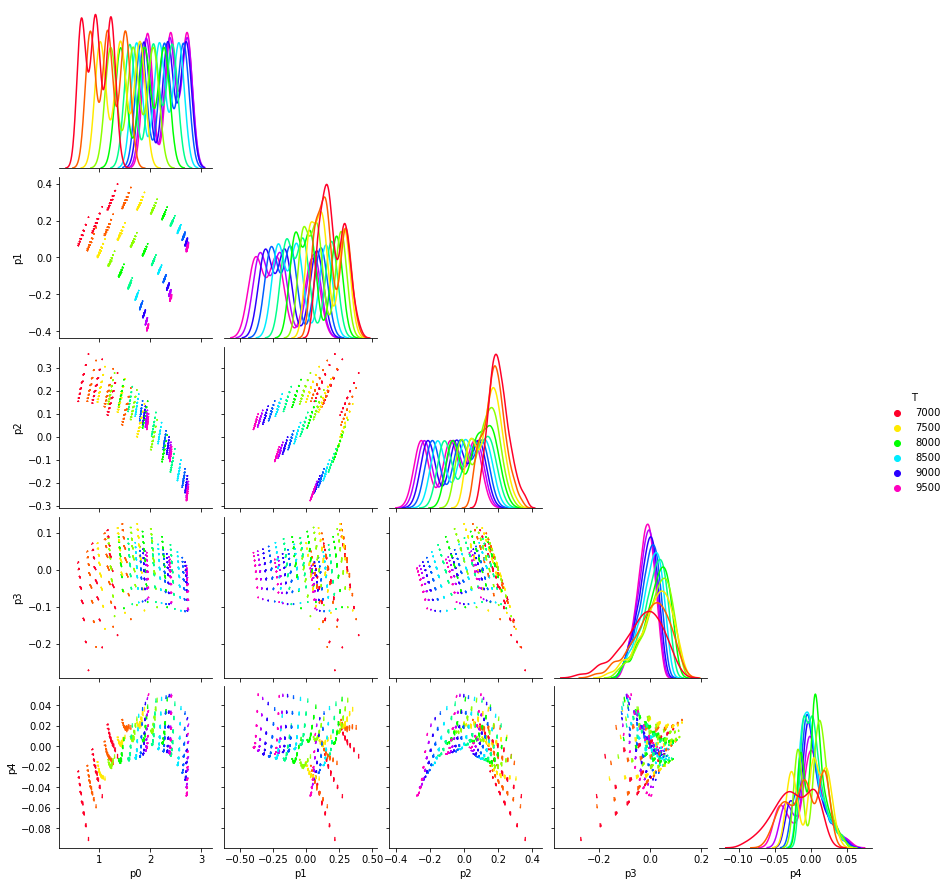

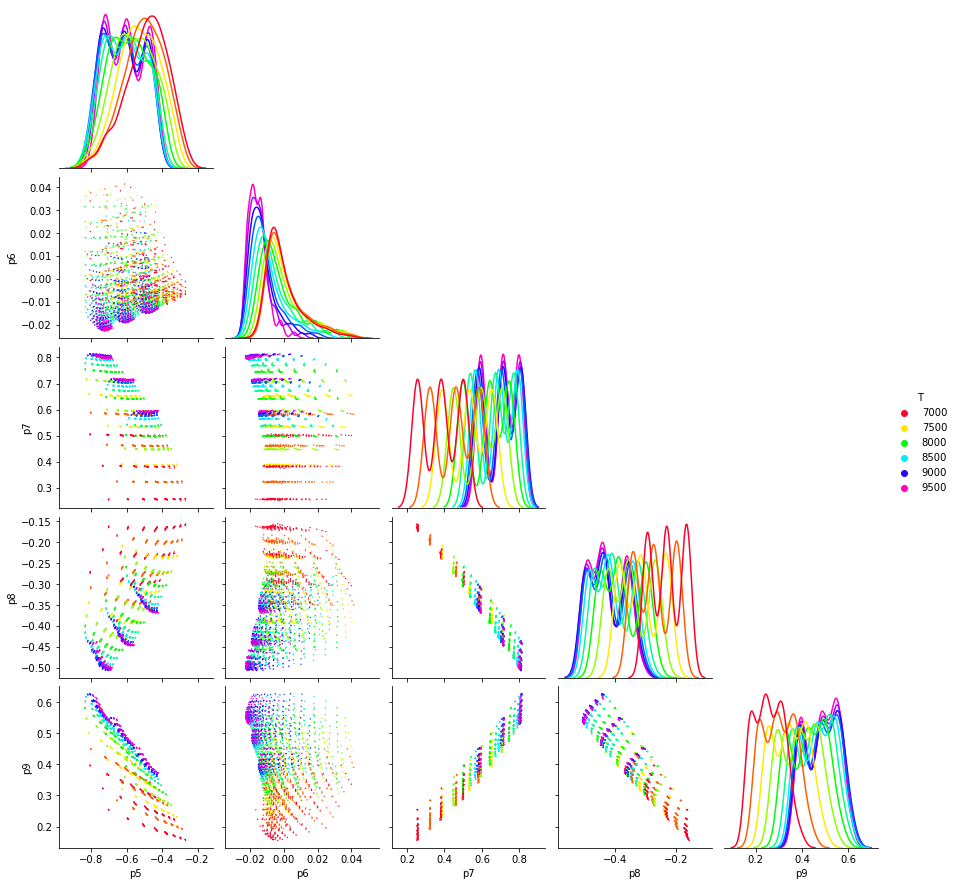

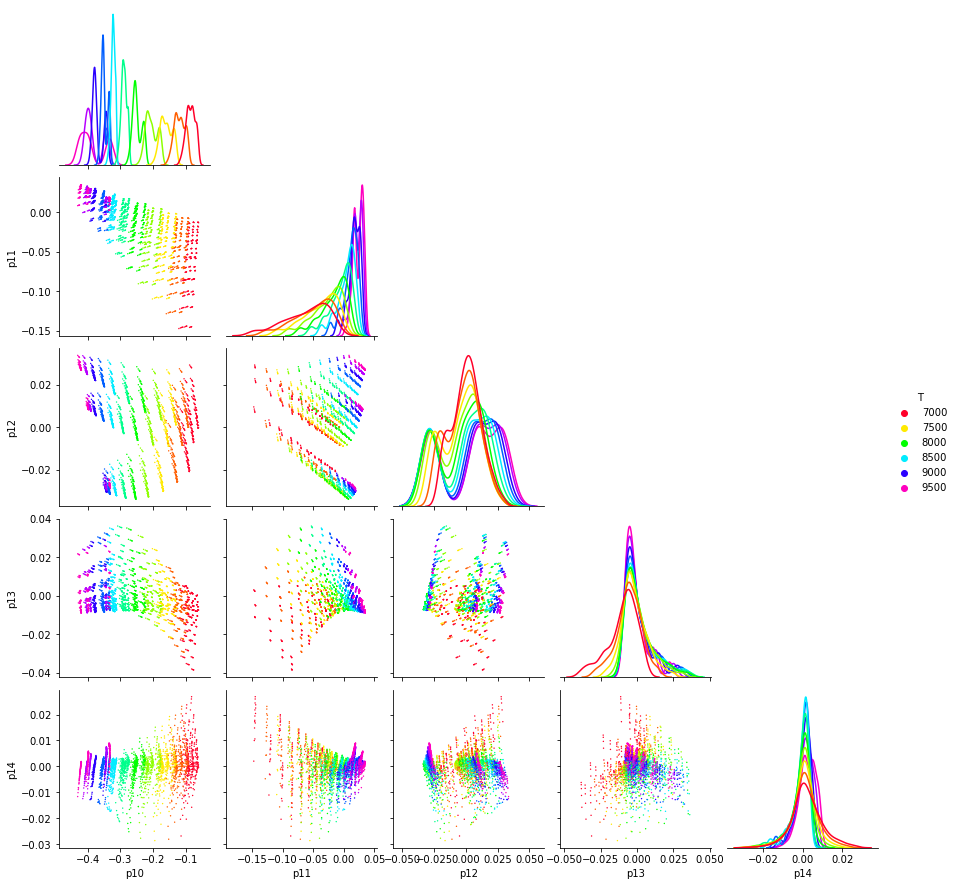

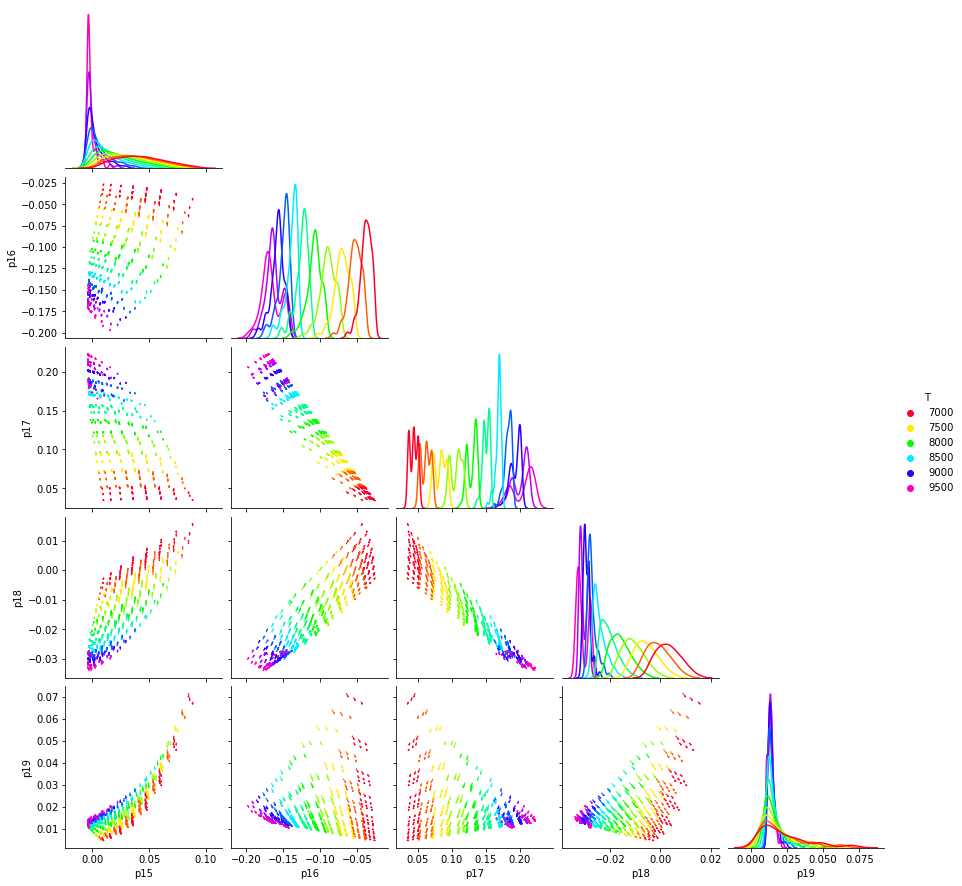

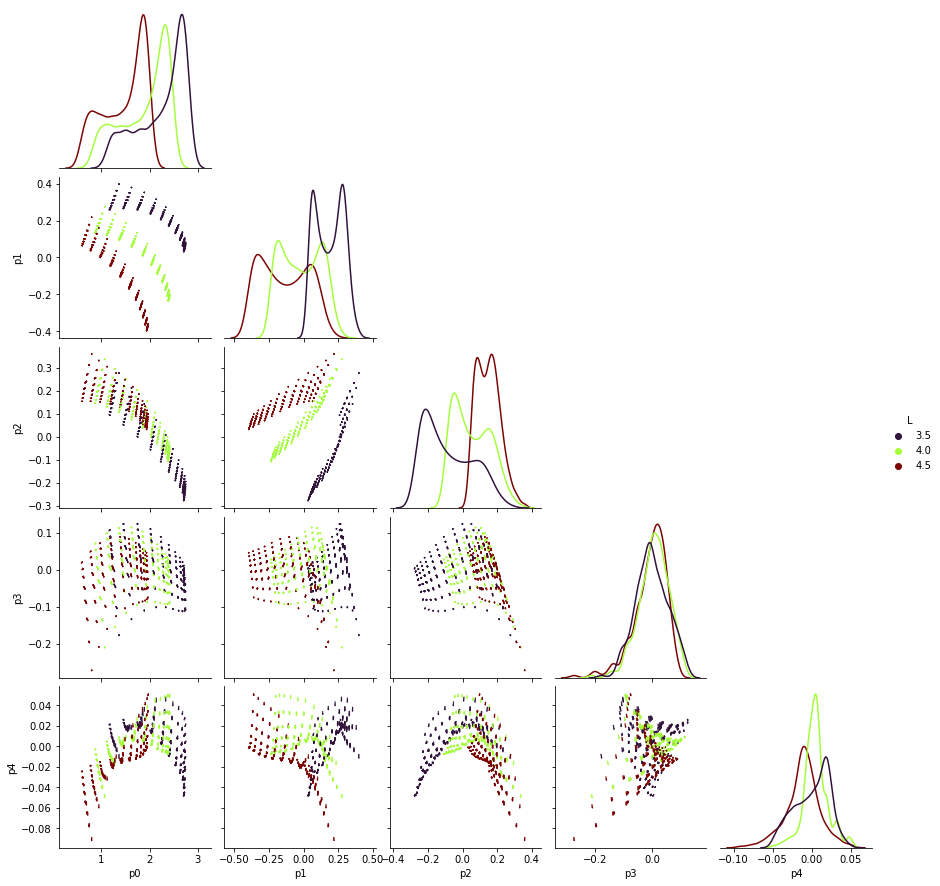

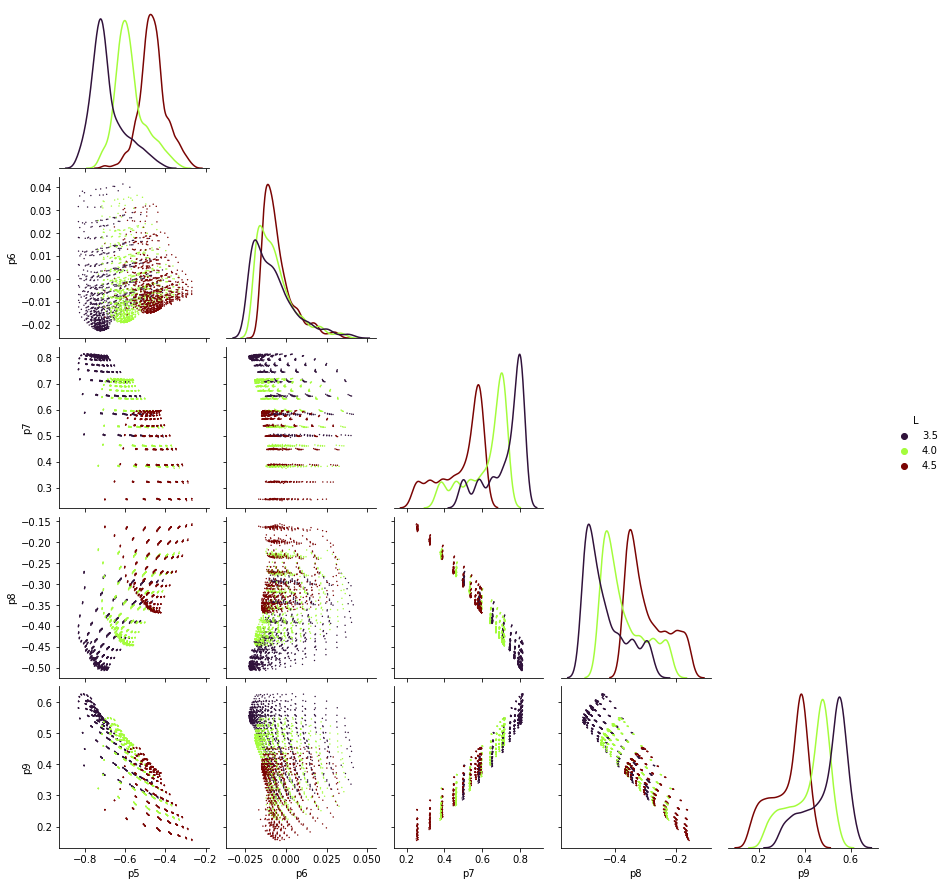

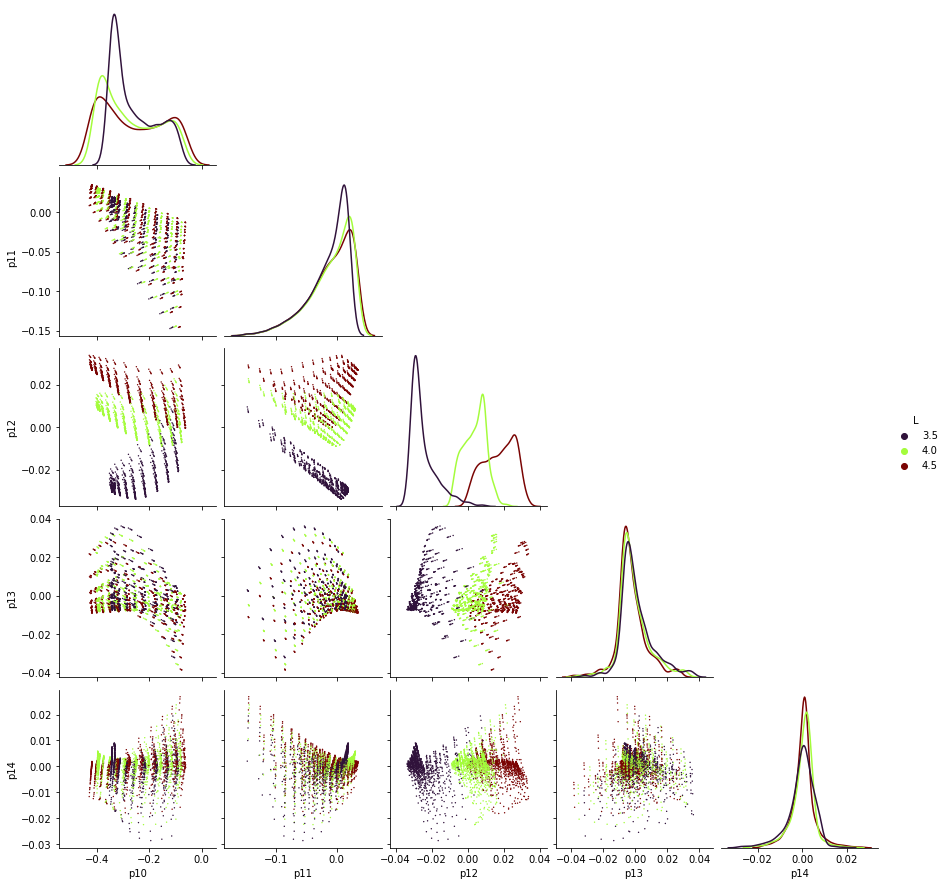

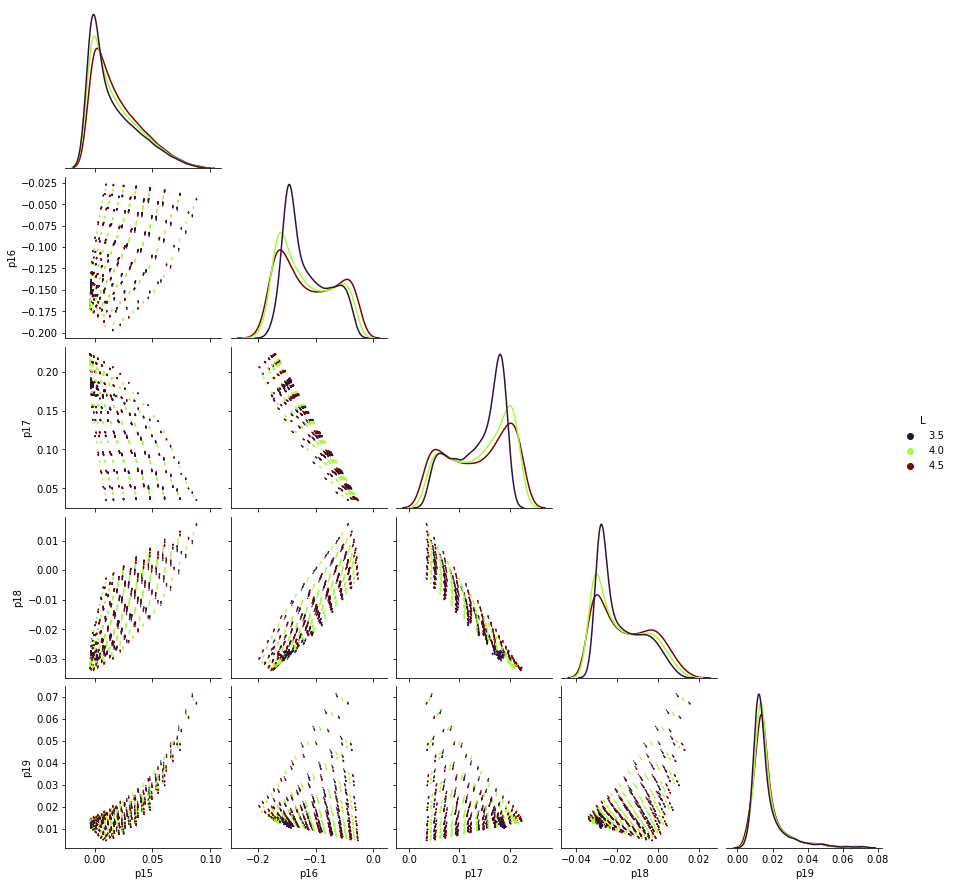

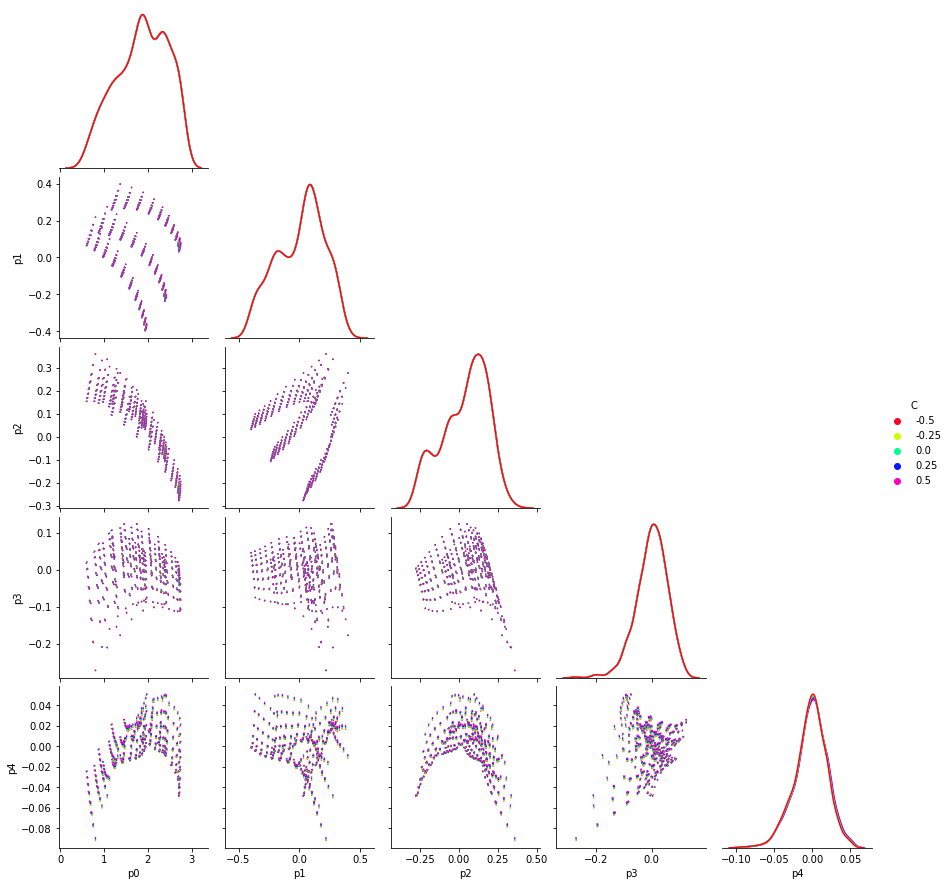

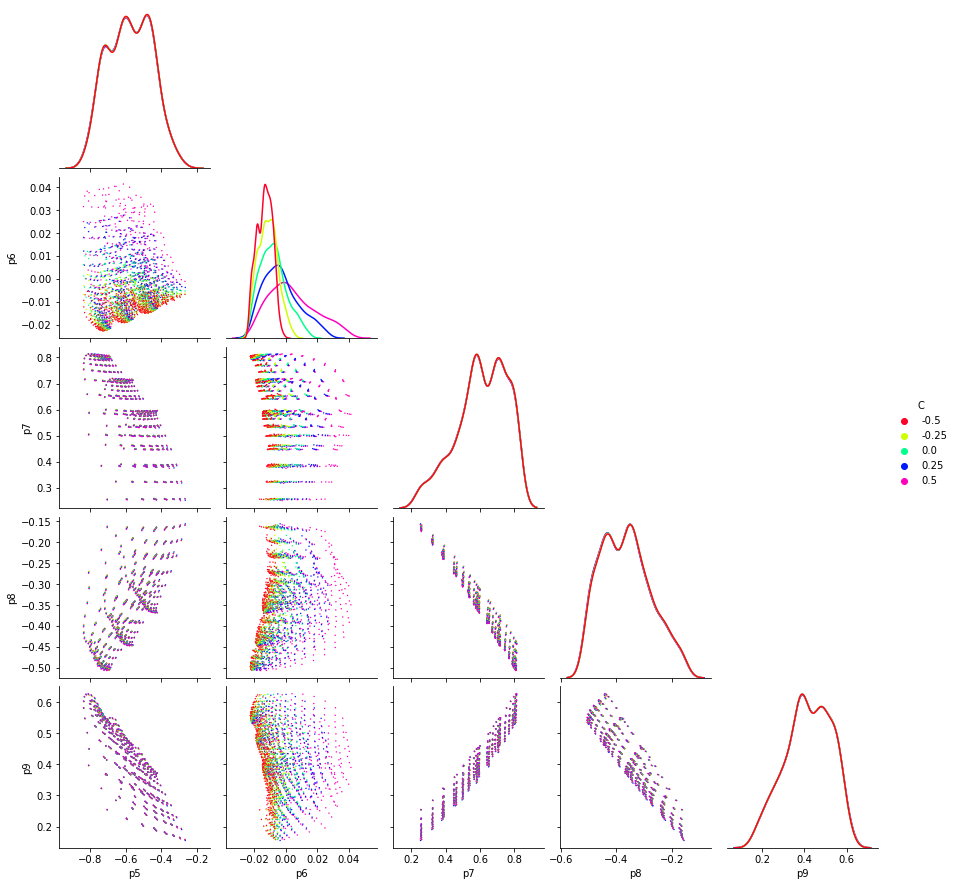

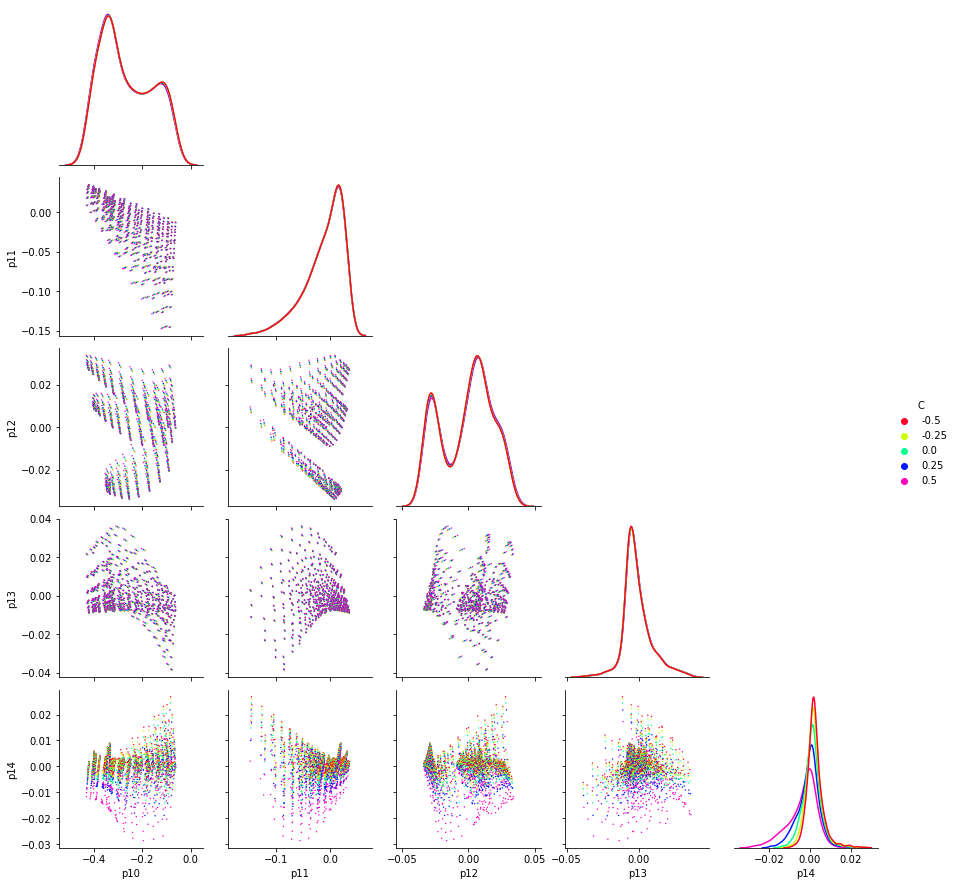

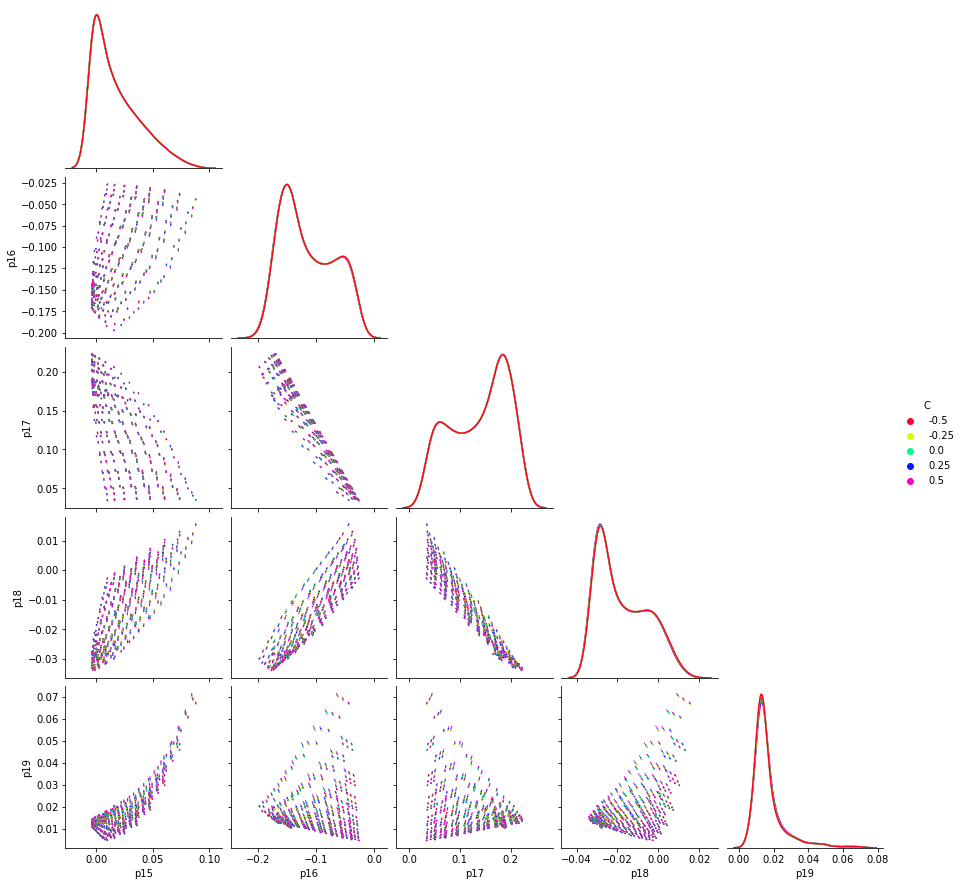

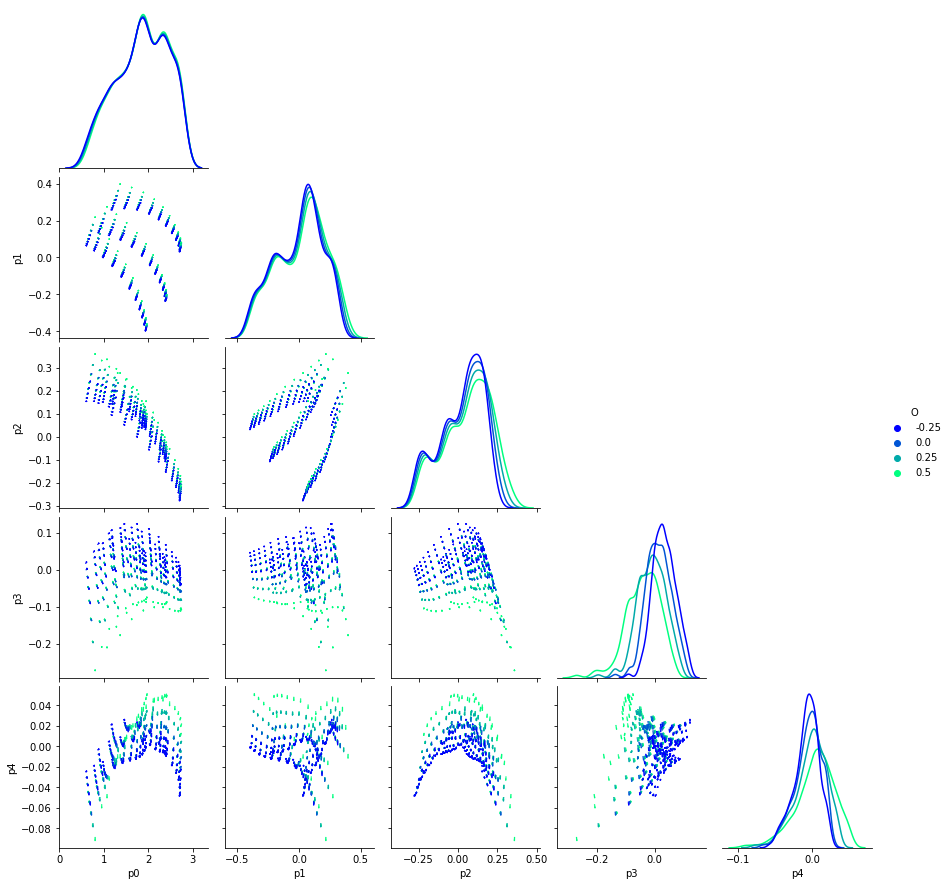

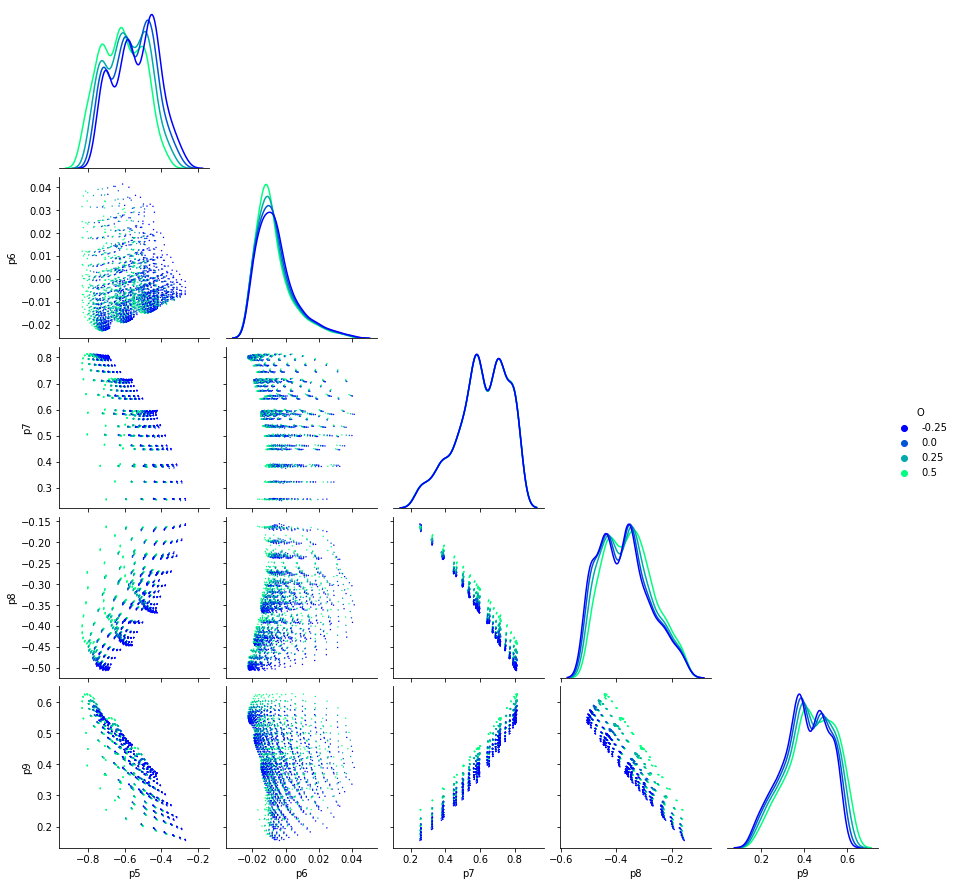

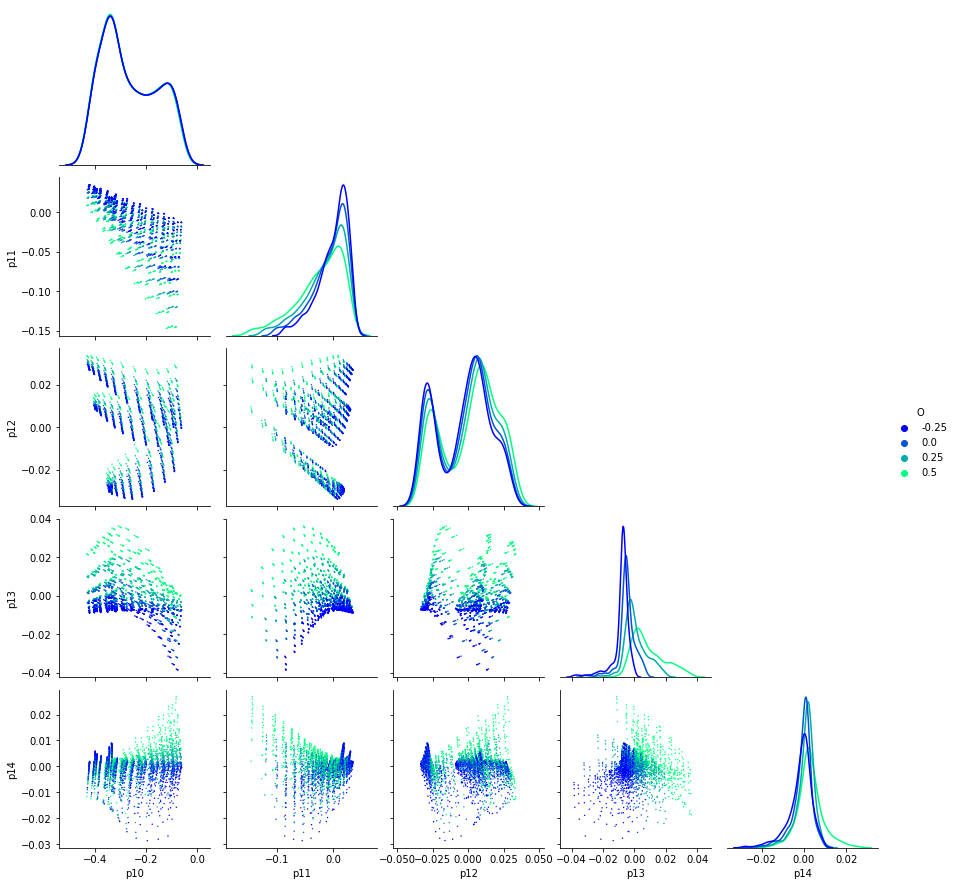

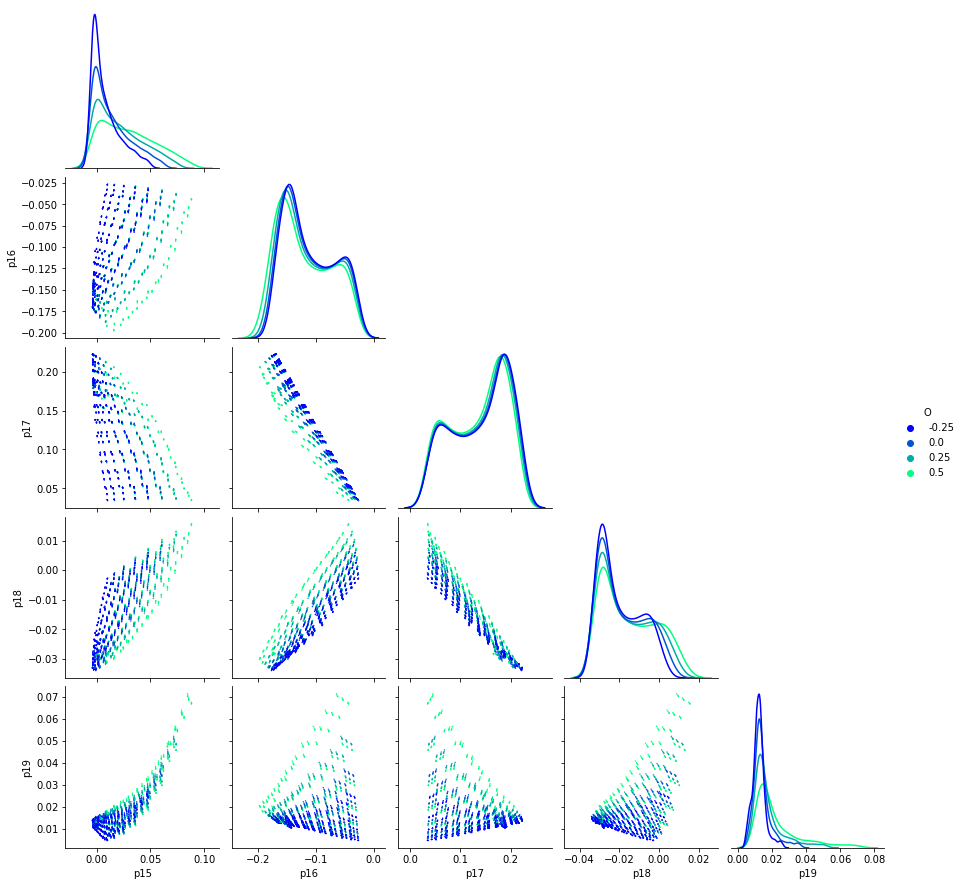

In [190]:
for p in ["F","T","L","C","O"]:
    for i in range(4):
        ds.pp(i, p)